In [1]:
import sys
import os
import geopandas as gpd
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.pardir)))

from VASA import VASA

In [2]:
cbg_data = pd.read_csv("../data/sg_cbg.csv")

In [3]:
selected_county_data = cbg_data[[c in [6037] for c in cbg_data["county_fips"]]][["distance_traveled_from_home", "cbg_fips", "date_range_start"]]
selected_county_data["fips"] = ["0" + str(f) for f in selected_county_data["cbg_fips"]]

In [4]:
selected_county_data=selected_county_data.drop("cbg_fips", axis=1)

In [5]:
all_counties = gpd.read_file("../data/ca_cbg")
#counties = all_counties[[c in ["037", "111", "029", "059"] for c in all_counties["COUNTYFP"]]]
counties = all_counties[[c in ["037"] for c in all_counties["COUNTYFP"]]] # just LA

counties_map = gpd.GeoDataFrame \
    .from_features(counties) \
    .set_crs(epsg=4326) \
    .to_crs("+proj=aea +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs")

In [6]:
filtered_map = counties_map[counties_map["ALAND"] != 0].reset_index(drop=True)

<AxesSubplot:>

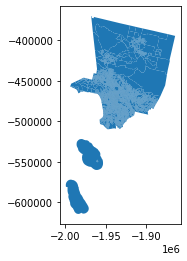

In [6]:
filtered_map.plot()

In [7]:
v = VASA(
    selected_county_data,
    filtered_map,
    gdf_group_col="GEOID",
    date_col="date_range_start",
    date_format="%Y-%m-%d %H:%M:%S%z"
)

In [8]:
v.group()

In [9]:
# d = np.array(v.df["distance_traveled_from_home"].tolist())

# toKeep = np.logical_not(np.all(np.isnan(d), axis=0))

# d[:, toKeep]
# newFips = v.fips_order[toKeep]

# print(len(newFips))
# newFips = pd.DataFrame({ "newFips": newFips})
# v.gdf.merge(newFips, left_on="GEOID", right_on="newFips", how="right").reset_index(drop=True)

In [23]:
d = np.array(v.df["distance_traveled_from_home"].tolist())

n_total = len(d[0])
n_all_missing = len(d[:, np.all(np.isnan(d), axis=0)][0])

pct_all_missing = n_all_missing / n_total * 100
n_all_missing, pct_all_missing, n_total

(1501, 22.787308334598453, 6587)

<AxesSubplot:>

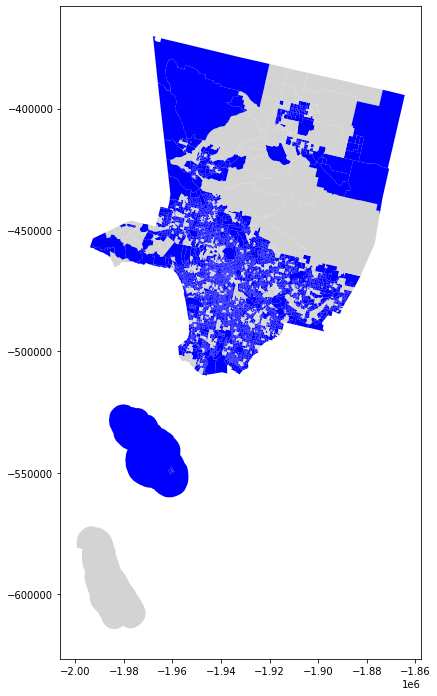

In [24]:
colorMap = pd.DataFrame()

colorMap["fips"] = v.fips_order
colorMap["color"] = [("lightgray" if c else "blue") for c in np.all(np.isnan(d), axis=0)]

merged_map = v.gdf.merge(
    colorMap, left_on="GEOID", right_on="fips"
)

merged_map

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
merged_map.plot(color=merged_map["color"], ax=ax)

In [13]:
n_partial_missing = len(d[:, np.any(np.isnan(d), axis=0)][0]) - n_all_missing

pct_partial_missing = n_partial_missing / n_total * 100
n_partial_missing, pct_partial_missing, n_total

(26, 0.39447731755424065, 6591)

(array([5.060e+03, 1.300e+01, 7.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        1.000e+00, 1.506e+03]),
 array([0.  , 0.01, 0.1 , 0.2 , 0.4 , 0.6 , 0.8 , 0.9 , 1.  ]),
 <BarContainer object of 8 artists>)

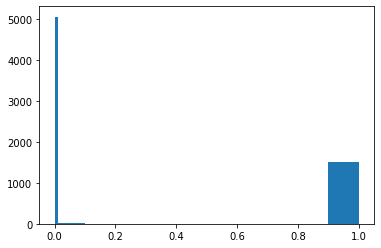

In [14]:
pct_missing_county = np.sum(np.isnan(d.T), axis=1) / d.shape[0]

import matplotlib.pyplot as mpl

mpl.hist(pct_missing_county, bins=[0, 0.01, 0.1, 0.2, 0.4, 0.6, 0.8, 0.9, 1])

[0.020833333333333332, 0.020833333333333332, 0.020833333333333332, 0.020833333333333332, 0.020833333333333332, 0.020833333333333332, 0.020833333333333332, 0.041666666666666664, 0.0625, 0.0625, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.10416666666666667, 0.10416666666666667, 0.10416666666666667, 0.14583333333333334, 0.14583333333333334, 0.14583333333333334, 0.14583333333333334, 0.25, 0.4166666666666667, 0.5416666666666666, 0.7916666666666666, 0.8125, 0.9166666666666666] 26


(array([16.,  4.,  1.,  0.,  1.,  1.,  0.,  0.,  2.,  1.]),
 array([0.02083333, 0.11041667, 0.2       , 0.28958333, 0.37916667,
        0.46875   , 0.55833333, 0.64791667, 0.7375    , 0.82708333,
        0.91666667]),
 <BarContainer object of 10 artists>)

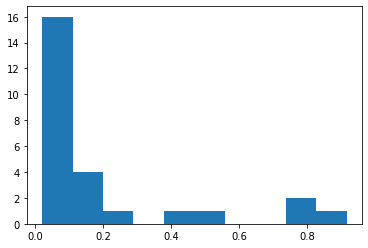

In [15]:
ser = pct_missing_county[[p != 1 and p != 0 for p in pct_missing_county]]
print(sorted(ser), len(ser))
mpl.hist(ser)

In [12]:
def moving_average(x):
    return np.convolve(np.nan_to_num(x), np.ones(7), 'same') / 7

def combine_ma(x):
    to_keep = np.logical_not(np.isnan(x))
    ma = moving_average(x)
    ma[to_keep] = x[to_keep]
    return ma

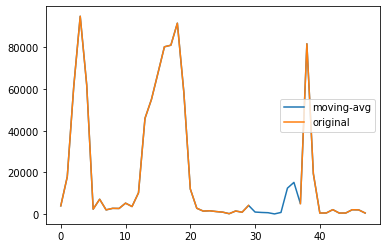

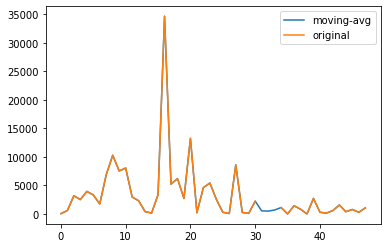

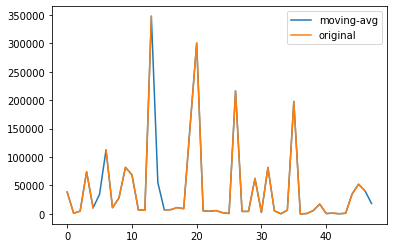

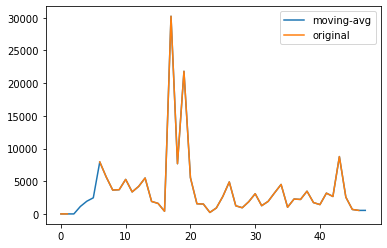

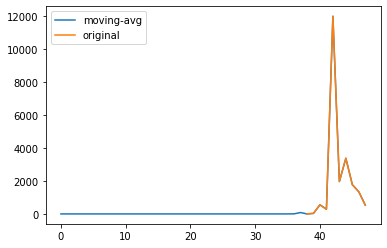

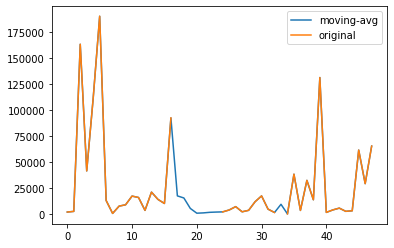

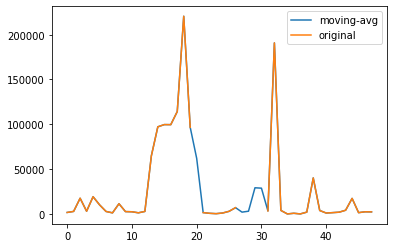

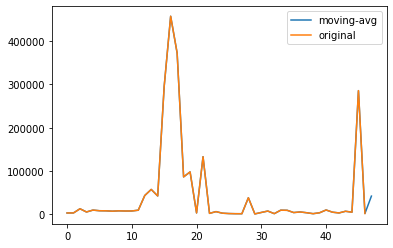

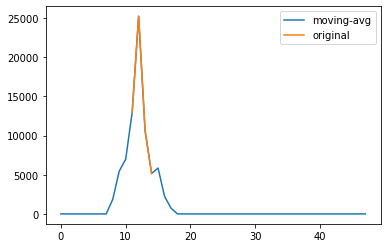

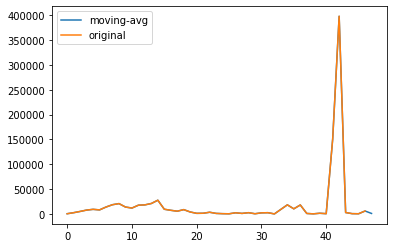

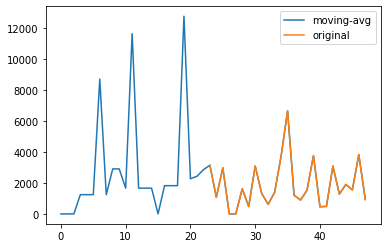

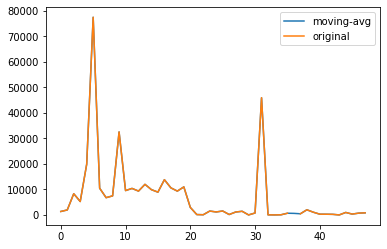

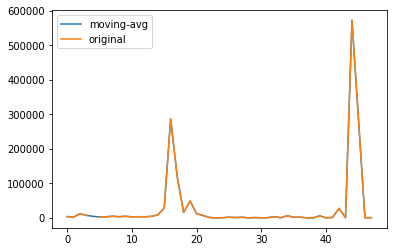

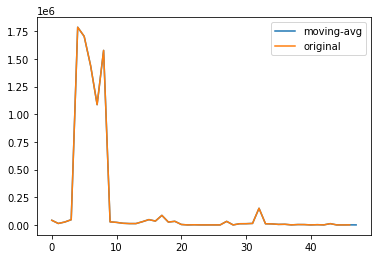

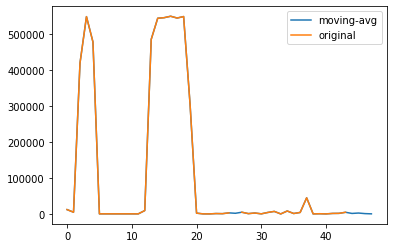

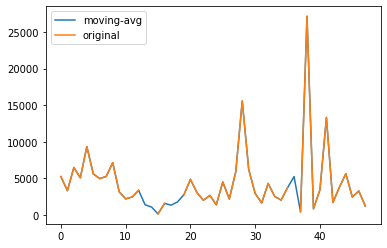

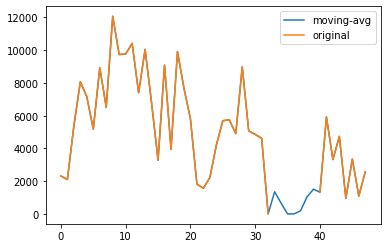

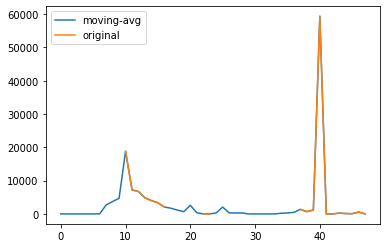

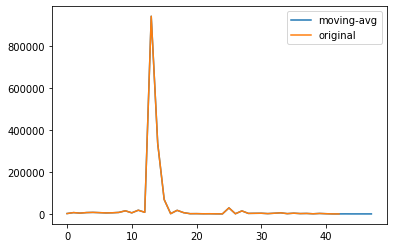

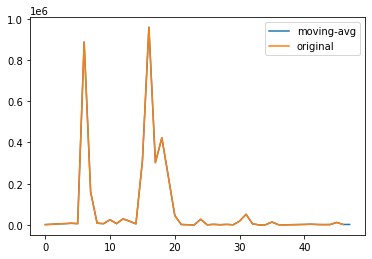

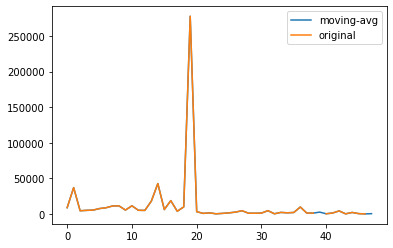

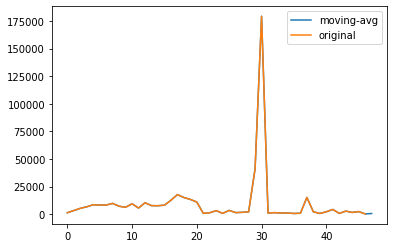

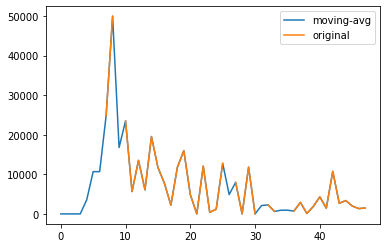

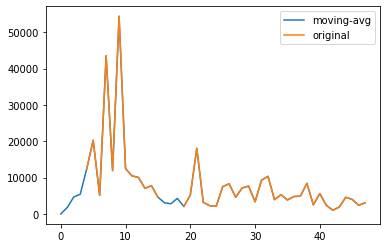

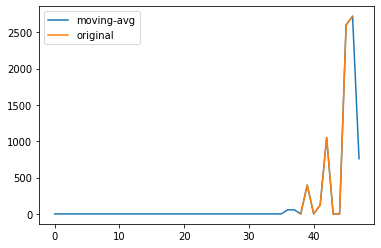

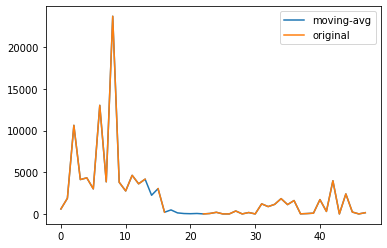

In [22]:
import matplotlib.pyplot as plt
any_missing = d[:, np.any(np.isnan(d), axis=0)]
partial_missing = any_missing[:, np.any(np.logical_not(np.isnan(any_missing)), axis=0)]

xs = np.arange(0, 48)
total = np.apply_along_axis(combine_ma, 0, partial_missing)

for i in range(26):

    to_remove = np.logical_not(np.isnan(partial_missing.T[i]))

    xs_rm = [np.nan if keep else xs[i] for i, keep in enumerate(to_remove)]
    ma = total[:, i] #combine_ma(partial_missing.T[i])


    plt.plot(xs, ma, label="moving-avg")
    plt.plot(xs, partial_missing.T[i], label="original")
    plt.legend()
    plt.show()


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3540.
  warnings.warn(message)


('WARNING: ', 3540, ' is an island (no neighbors)')


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

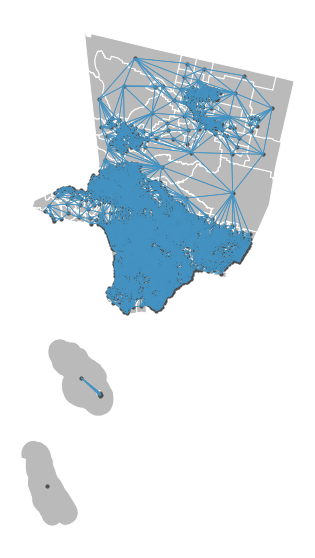

In [37]:
# Queens weights
import libpysal as lps
from splot.libpysal import plot_spatial_weights
W = lps.weights.Queen(v.gdf["geometry"])
W.transform = 'r'
plot_spatial_weights(W, v.gdf)

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


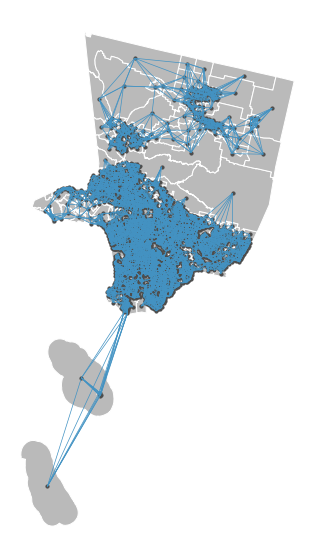

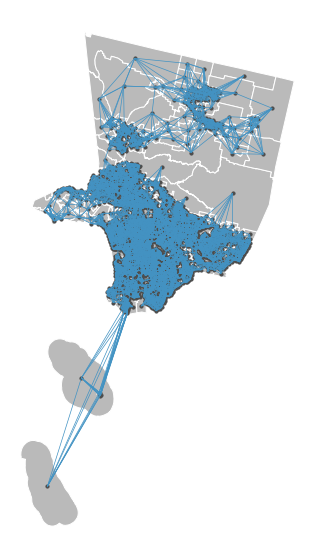

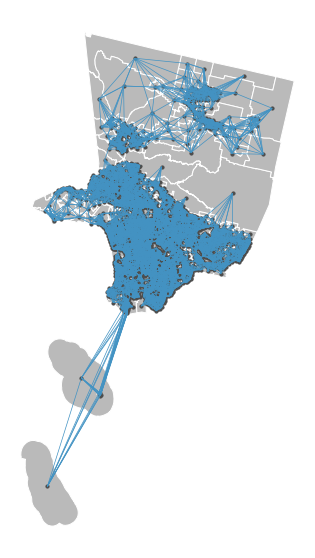

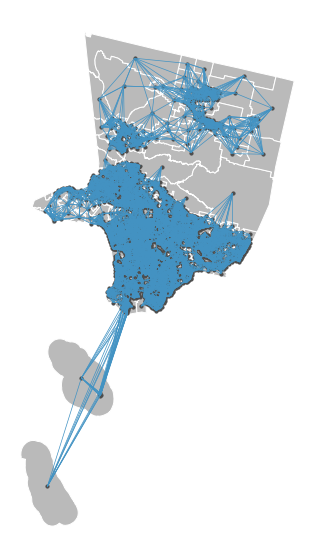

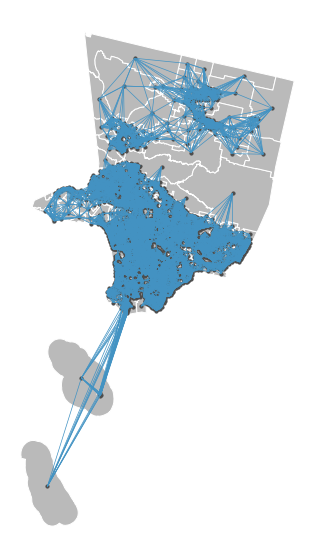

In [38]:
#KNN
for k in [6, 7, 8, 9, 10]:
    W = lps.weights.KNN.from_dataframe(v.gdf, "geometry", k=k)
    plot_spatial_weights(W, v.gdf)

/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There is 1 island with id: 3540.
  warnings.warn(message)


('WARNING: ', 3540, ' is an island (no neighbors)')
islands:  [3540]


/home/alex/Desktop/github/VASA/myenv/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
  warnings.warn(message)


attached islands: [] {3525: 1.0}


(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

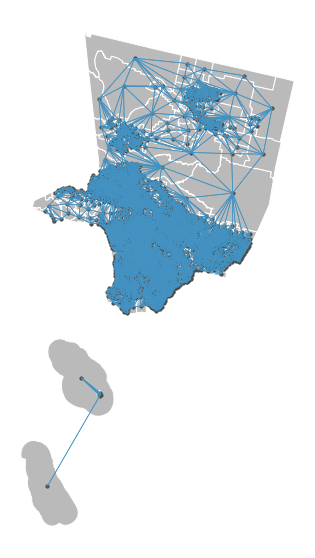

In [39]:
# ATTACH ISLANDS
import libpysal as lbs

w = lps.weights.Queen(v.gdf["geometry"])
w.transform = 'r'
print("islands: ", w.islands)

w_knn = lps.weights.KNN.from_dataframe(v.gdf, "geometry", k=6)
w_attach = lps.weights.attach_islands(w, w_knn)

print("attached islands:", w_attach.islands, w_attach[w.islands[0]])
plot_spatial_weights(w_attach, v.gdf)

In [10]:
v.dropMissing()
d = np.array(v.df["distance_traveled_from_home"].tolist())
n_all_missing = len(d[:, np.all(np.isnan(d), axis=0)][0])
n_all_missing

0

In [12]:
v.impute()

d = np.array(v.df["distance_traveled_from_home"].tolist())
n_partial_missing = len(d[:, np.any(np.isnan(d), axis=0)][0])
n_partial_missing

0

In [15]:
len(v.df["distance_traveled_from_home"][0])

5086

In [18]:
len(v.fips_order)

5086

In [19]:
v.gdf.shape

(5086, 14)

In [20]:
v.lisa(k=7)

(<Figure size 720x720 with 1 Axes>, <AxesSubplot:>)

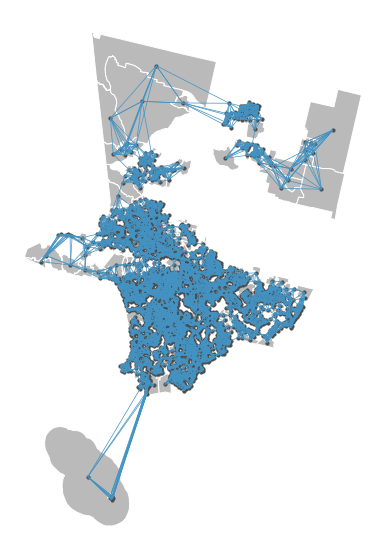

In [21]:
import libpysal as lps
from splot.libpysal import plot_spatial_weights
plot_spatial_weights(v.W, v.gdf)

In [24]:
v.df

,date,distance_traveled_from_home
0,2019-12-21,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,2019-12-23,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2019-12-30,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,2020-01-06,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,2020-01-13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,2020-01-20,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,2020-01-27,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
7,2020-02-03,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,2020-02-10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,2020-02-17,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Empty DataFrame
Columns: [distance_traveled_from_home_count, recent, count, which]
Index: []
POINTS HEAD


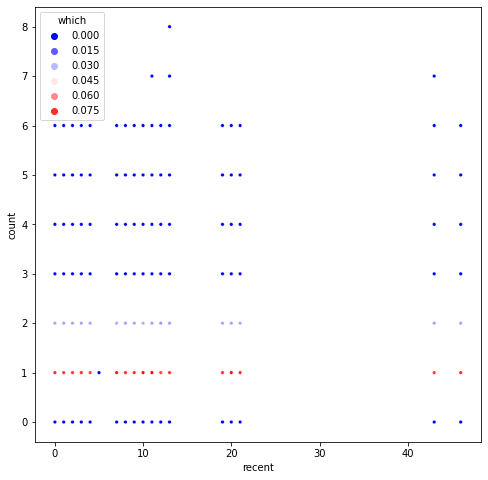

In [25]:
from VASA.scatter import Scatter
scatplt = Scatter(v)
scatplt.plot()